## Background

* DOMAIN: Manufacturing
* CONTEXT: Company X curates and packages wine across various vineyards spread throughout the country.
* DATA DESCRIPTION: The data concerns the chemical composition of the wine and its respective quality.
* Attribute Information:
    1. A, B, C, D: specific chemical composition measure of the wine
    2. Quality: quality of wine [ Low and High ]
* PROJECT OBJECTIVE: Goal is to build a synthetic data generation model using the existing data provided by the company.

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
from copy import deepcopy

import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy.stats import zscore

# To see multiple outputs together

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_excel('Part2 - Company.xlsx')

In [3]:
df.head()

,A,B,C,D,Quality
0,47,27,45,108,Quality A
1,174,133,134,166,Quality B
2,159,163,135,131,NaN
3,61,23,3,44,Quality A
4,59,60,9,68,Quality A


Before checking the missing values we check for any duplicates in data

In [4]:
##Identify duplicates records in the data

dupes = df.duplicated()
if sum(dupes) == 0:
    print("There is no duplicates in the data")
else:
    df =df.drop_duplicates()
    dupes_check = df.duplicated()
    sum(dupes_check)

There is no duplicates in the data


In [5]:
# Number of missing values (only the ones recognised as missing values) in each of the attributes

pd.DataFrame( df.isnull().sum(), columns= ['Number of missing values'])

,Number of missing values
A,0
B,0
C,0
D,0
Quality,18


* Only the variable Quality has 18 missing values.
* We will run an info() to check if there is anything to doubt about presence of missing values for the other attributes.

In [6]:
# Check data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   A        61 non-null     int64 
 1   B        61 non-null     int64 
 2   C        61 non-null     int64 
 3   D        61 non-null     int64 
 4   Quality  43 non-null     object
dtypes: int64(4), object(1)
memory usage: 2.5+ KB


The data types for all the attributes are integer and that is how it is supposed to be. So, we do not suspect presence of any special character as missing values. However, we need to check for 0's.

In [7]:
# Check for 0 values in the features

print("Percentage of 0's in A:",100*((df['A'] == 0)).sum()/len(df.index))
print("Percentage of 0's in B:",100*((df['B'] == 0)).sum()/len(df.index))
print("Percentage of 0's in C:",100*((df['C'] == 0)).sum()/len(df.index))
print("Percentage of 0's in D:",100*((df['D'] == 0)).sum()/len(df.index))

Percentage of 0's in A: 0.0
Percentage of 0's in B: 0.0
Percentage of 0's in C: 0.0
Percentage of 0's in D: 0.0


Now, we are sure that there is no missing values in any of the attributes A-D.

#### Approach to impute missing values for Quality

The  missing values for "Quality" can be imputed through methods like imputing by mode or by applying some classification technique using the attributes A-D as predictors.

However, here we will approach it differently. We will use usupervised learning techniques.
Example : We will cluster the observations based on attributes A-D. This will also allow the missing values of "Quality" to fall in some cluster. Then we can use the non-missing observations to verify if the missing value imputation through clustering has been correct.

In [8]:
# Dropping the Quality variable from data and applying scaling through z-scores

wine = df.copy()
wine = df.drop('Quality',axis=1)

wine_scaled=wine.apply(zscore)

In [9]:
wine_scaled.head()

,A,B,C,D
0,-1.168034,-1.561080,-1.061569,-0.103138
1,0.904992,0.284923,0.306077,0.823013
2,0.660147,0.807376,0.321443,0.264129
3,-0.939512,-1.630740,-1.706975,-1.125099
4,-0.972158,-0.986381,-1.614775,-0.741864


Since we have two types of qualities, we can say there may be two clusters. However, we will use the elbow method to cross-check.

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=1)

KMeans(n_clusters=2)

KMeans(n_clusters=3)

KMeans(n_clusters=4)

Text(0.5, 0, 'k')

Text(0, 0.5, 'Average distortion')

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

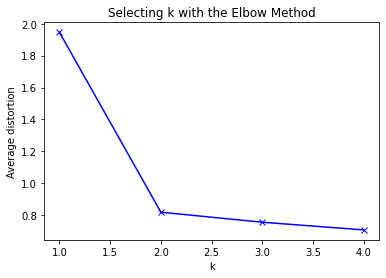

In [10]:
clusters=range(1,5)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(wine_scaled)
    prediction=model.predict(wine_scaled)
    meanDistortions.append(sum(np.min(cdist(wine_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / wine_scaled.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

The elbow curve shows that we will proceed with two clusters.

In [11]:
# Fitting 2 clusters and assigning groups

cluster=KMeans(2)
cluster.fit(wine_scaled)
prediction=cluster.predict(wine_scaled)

#Append the prediction 
df["GROUP"] = prediction
df["GROUP"] = prediction
print("Groups Assigned : \n")
df.head()

KMeans(n_clusters=2)

Groups Assigned : 



,A,B,C,D,Quality,GROUP
0,47,27,45,108,Quality A,0
1,174,133,134,166,Quality B,1
2,159,163,135,131,NaN,1
3,61,23,3,44,Quality A,0
4,59,60,9,68,Quality A,0


In [12]:
# Calculating silhouette_score
silhouette_score(wine_scaled,cluster.labels_)

0.6891674125195145

Since a Silhoutte score of close to 1 indicate that an observation is far from its neighbouring cluster and near to its own cluster, we can say that clustering done through k-means with 2 clusters seems good.

#### Verify the imputation done through clustering

1. Remove the observations with missing values
2. For the remaining, check with the help of a cross-tab whether there has been any mis-classification of the groups comparing it with the Quality variable.

In [13]:
# Dropping missing values
wine = df.copy() 
wine = wine.dropna()

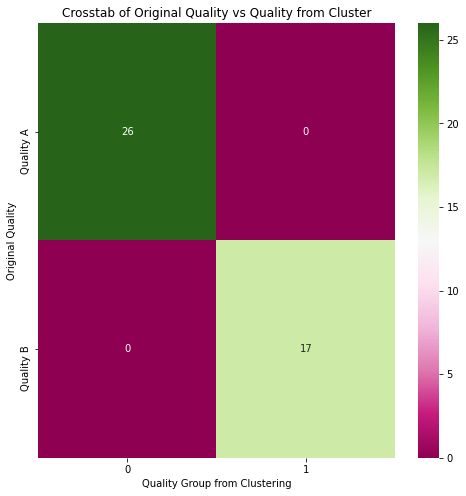

In [14]:
# Computing the crosstab and visualising it through a heatmap (Quality A is 1 and Quality B is 0)

val=pd.crosstab(index=wine['Quality'], columns=wine['GROUP'])

plt.figure(figsize = (8, 8))
sns.heatmap(val, annot = True, cmap = 'PiYG', fmt = 'd')
plt.xlabel('Quality Group from Clustering')
plt.ylabel('Original Quality')
plt.title('Crosstab of Original Quality vs Quality from Cluster');

From the above crosstab, we can conclude that the imputation through clustering has given us the desired result as there is no mis-classification.

#### Missing Value Imputation through knn Imputer

1. Change Quality A to 0 and Quality B to 1, since knn Imputer does not work on object type data
2. For the non-missing we check using a cross-tab how good the imputation has been

In [15]:
# Replacing Quality A with 1 and Quality B with B

wi_knnimp = df.copy()
wi_knnimp['Quality'] = wi_knnimp['Quality'].replace({'Quality A':1, 'Quality B':0})
wi_knnimp = wi_knnimp.drop('GROUP',axis=1)

In [16]:
wi_knnimp.head(10)

,A,B,C,D,Quality
0,47,27,45,108,1.0
1,174,133,134,166,0.0
2,159,163,135,131,NaN
3,61,23,3,44,1.0
4,59,60,9,68,1.0
5,153,140,154,199,NaN
6,34,28,78,22,1.0
7,191,144,143,154,NaN
8,160,181,194,178,0.0
9,145,178,158,141,NaN


In [17]:
imputer = KNNImputer(n_neighbors=2)
wine_filled = pd.DataFrame(imputer.fit_transform(wi_knnimp),columns = wi_knnimp.columns)

In [18]:
wine_filled

,A,B,C,D,Quality
0,47.0,27.0,45.0,108.0,1.0
1,174.0,133.0,134.0,166.0,0.0
2,159.0,163.0,135.0,131.0,0.0
3,61.0,23.0,3.0,44.0,1.0
4,59.0,60.0,9.0,68.0,1.0
...,...,...,...,...,...
56,200.0,186.0,185.0,179.0,0.0
57,137.0,182.0,165.0,199.0,0.0
58,88.0,39.0,9.0,102.0,1.0
59,180.0,157.0,192.0,198.0,0.0


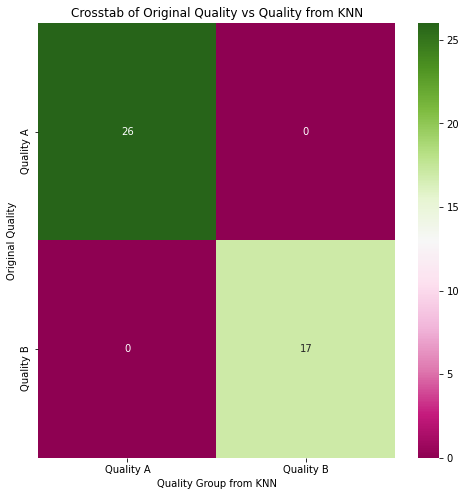

In [19]:
# Computing the crosstab and visualising it through a heatmap

val=pd.crosstab(index=wine_filled['Quality'], columns=df['Quality'])

plt.figure(figsize = (8, 8))
sns.heatmap(val, annot = True, cmap = 'PiYG', fmt = 'd')
plt.xlabel('Quality Group from KNN')
plt.ylabel('Original Quality')
plt.title('Crosstab of Original Quality vs Quality from KNN');

Hence, for the non-missing ones - we see there is no miss-classification.

Thus by both methods we get correct imputation.